In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

/Users/adrian/miniconda3/envs/sml-jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### In this notebook we are going to do 3 things:
1. Create a feature view
2. Train several classifiers and regression models and evaluate their performance on the test set
3. Upload one of the better models to Hopsworks to be used with the other programs.

In [50]:
# Login to hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193686
Connected. Call `.close()` to terminate connection gracefully.


In [51]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view

wine_fg = fs.get_feature_group(name='wine', version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name='wine',
                                  version=1,
                                  description='Read from Wine quality dataset',
                                  labels=['quality'],
                                  query=query)

### Splitting the dataset and trying out our models

In [52]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (4.17s) 


In [58]:
# Lets define our models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

clf1 = DecisionTreeClassifier(max_depth=5)
p1 = {'max_depth': [1, 5, 10, 20]}
clf2 = KNeighborsClassifier(n_neighbors=4)
p2 = {'n_neighbors': [1, 3, 5, 7]}
clf3 = RandomForestClassifier()
p3 = {'max_depth': [1, 5, 10, 20]}
clf4 = SVC()
p4 = {'kernel': ['linear','rbf']}

models = [clf1,clf2,clf3,clf4]
params_to_be_tuned = [p1,p2,p3,p4]

In [55]:
def hyperparameter_tuning(model, params, X_train, y_train):
    gs = GridSearchCV(model,
                        param_grid=params,
                        scoring='accuracy',
                        cv=3)

    gs.fit(X_train,y_train)
    return gs

### Training and tuning the models

In [61]:
tuned_models = []
for i in range(len(models)):
    print(f'Tuning model {i+1}')
    tuned_model = hyperparameter_tuning(models[i], params_to_be_tuned[i], X_train, y_train.values.ravel())
    tuned_models.append(tuned_model)

### Evaluating the models

In [67]:
preds = [model.predict(X_test) for model in tuned_models]
accs = [accuracy_score(y_test,y_pred) for y_pred in preds]
f1s = [f1_score(y_test,y_pred,average='weighted') for y_pred in preds]

print(accs)
print(f1s)

[0.5337711069418386, 0.44183864915572235, 0.575046904315197, 0.5347091932457786]
[0.5082506598585352, 0.41872971653938484, 0.5566421070234541, 0.4657941496662869]


In [43]:
n_max_class = y_val.reset_index().groupby('quality').count()['index'].max()
n_total = len(y_val)
benchmark = n_max_class/n_total

print(benchmark)

0.4530956848030019


We can see that the models do perform better than the benchmark, the benchmark here being a very naive  
approach where we just classify everything as the most common class. 

The benchmark is **45.3 %** and the best performing model did get **57.5 %** accuracy on the test set.

While this is not a lot better than the benchmark, it does seem like the bulk of the extra work should  
actually go to feature engineering, like cutting down or changing features and reducing colinearity,   
and not to tune parameters and selecting models.

Another thing that would be of a very high level of importance would be to reframe the problem, possibly  
as a binary classification of good wines vs bad wines where the classes are decided on a certain number  
of the quality label.

Below we can see the model that performed the best and the hyperparameter that worked best for this task.

In [75]:
best_model = tuned_models[2]
print(best_model.estimator, best_model.best_params_)

RandomForestClassifier() {'max_depth': 20}


Lets also take a more in depth look at the metrics for each of the classes  
and also a look at a confusion matrix

In [83]:
y_pred = best_model.predict(X_test)

metrics = classification_report(y_test, y_pred, output_dict=True, zero_division=True)

pd.DataFrame(metrics).transpose()

,precision,recall,f1-score,support
3,1.000000,0.000000,0.000000,6.000000
4,0.428571,0.071429,0.122449,42.000000
5,0.599469,0.626039,0.612466,361.000000
6,0.561939,0.678959,0.614931,461.000000
7,0.564516,0.402299,0.469799,174.000000
8,1.000000,0.047619,0.090909,21.000000
9,1.000000,0.000000,0.000000,1.000000
accuracy,0.575047,0.575047,0.575047,0.575047
macro avg,0.736357,0.260906,0.272936,1066.000000
weighted avg,0.581321,0.575047,0.556642,1066.000000


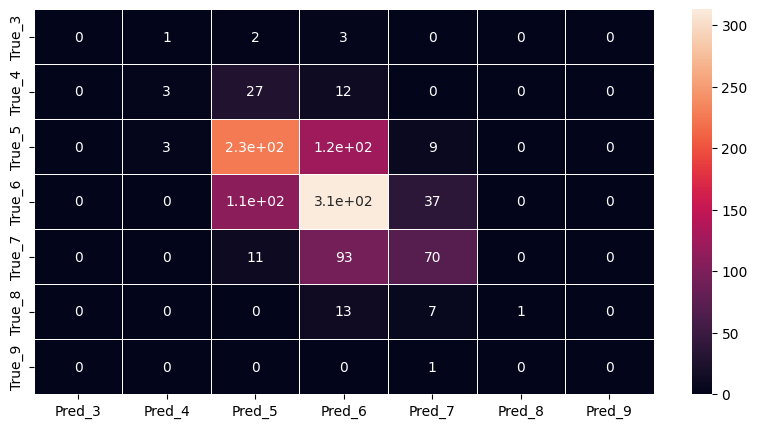

In [89]:
rows = [f'True_{classNumber}' for classNumber in range(3,10)]
cols = [f'Pred_{classNumber}' for classNumber in range(3,10)]

conf_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,rows,cols)

pyplot.figure(figsize=(10,5))
g = sns.heatmap(confusion_matrix_df,annot=True,lw=.5)
fig = g.get_figure()

As previously hypothesised we can see that the recall for any other class than 5 and 6 is abysmally low.
We would probably need more data, or to reframe the question somewhat in order for models to do much better  

However, it is still ok performance given the scope of the assignment.

Lets **save** this model to a folder in the repository and lets also **upload it to hopsworks**

In [90]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(best_model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 30471/30471 elapsed<00:01 remaining<00:001,  2.88it/s]
Uploading: 100.000%|██████████| 26316047/26316047 elapsed<00:43 remaining<00:0088it/s]
Uploading: 100.000%|██████████| 935/935 elapsed<00:01 remaining<00:00<01:47, 26.95s/it]
Model export complete: 100%|██████████| 6/6 [00:54<00:00,  9.04s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/193686/models/wine_model/1


Model(name: 'wine_model', version: 1)